# **Data Exploration - Fine-tuning XLSR-Wav2Vec2**

In [ ]:
%%capture
!pip install datasets==1.4.1
# !pip install transformers==4.4.0
!pip install torchaudio
!pip install librosa
!pip install jiwer

In [ ]:
%%capture
!pip install git+https://github.com/huggingface/transformers.git

In [ ]:
%%capture
!pip install wandb --upgrade

In [ ]:
import os
import wandb

# W&B company account
%env WANDB_ENTITY = wandb
entity = os.environ["WANDB_ENTITY"]

# Choose the public W&B project
%env WANDB_PROJECT = xlsr-irish
project_name = os.environ["WANDB_PROJECT"]

# Log your trained model to W&B as an Artifact
%env WANDB_LOG_MODEL = true 

env: WANDB_ENTITY=wandb
env: WANDB_PROJECT=xlsr-irish
env: WANDB_LOG_MODEL=true


In [ ]:
wandb.login()

wandb: Currently logged in as: morgan-test (use `wandb login --relogin` to force relogin)


True

## Prepare Data, Tokenizer, Feature Extractor

### Create Wav2Vec2CTCTokenizer

In [ ]:
from datasets import load_dataset, load_metric

# common_voice_train = load_dataset("common_voice", "tr", split="train+validation", cache_dir='data')
# common_voice_test = load_dataset("common_voice", "tr", split="test", cache_dir='data')

common_voice_train = load_dataset("common_voice", "ga-IE", split="train+validation", cache_dir='data',
                                 download_mode='force_redownload')
common_voice_test = load_dataset("common_voice", "ga-IE", split="test", cache_dir='data',
                                download_mode='force_redownload')

Dataset common_voice downloaded and prepared to data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f. Subsequent calls will reuse this data.


Dataset common_voice downloaded and prepared to data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f. Subsequent calls will reuse this data.


In [ ]:
common_voice_train, common_voice_test

(Dataset({
     features: ['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
     num_rows: 1038
 }),
 Dataset({
     features: ['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
     num_rows: 506
 }))

Many ASR datasets only provide the target text, `'sentence'` for each audio file `'path'`. Common Voice actually provides much more information about each audio file, such as the `'accent'`, etc. However, we want to keep the notebook as general as possible, so that we will only consider the transcribed text for fine-tuning.



In [ ]:
# common_voice_train = common_voice_train.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
# common_voice_test = common_voice_test.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])

In [ ]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\(\)\*]'

def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_ignore_regex, '', batch["sentence"]).lower() + " "
    return batch

In [ ]:
common_voice_train = common_voice_train.map(remove_special_characters)
common_voice_test = common_voice_test.map(remove_special_characters)

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
vocab_test = common_voice_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [ ]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
len(vocab_dict.keys()), vocab_dict

(33,
 {'b': 0,
  '’': 1,
  'i': 2,
  'm': 3,
  'ú': 4,
  'f': 5,
  '–': 6,
  'g': 7,
  'p': 8,
  'r': 9,
  'w': 10,
  'í': 11,
  't': 12,
  'c': 13,
  'v': 14,
  'u': 15,
  'k': 16,
  'x': 17,
  'e': 18,
  'y': 19,
  'h': 20,
  'é': 21,
  's': 22,
  'a': 23,
  'n': 24,
  'á': 25,
  'd': 26,
  'o': 27,
  'l': 28,
  ' ': 29,
  'ó': 30,
  'j': 31,
  "'": 32})

Cool, we see that all letters of the alphabet occur in the dataset (which is not really surprising) and we also extracted the special characters `" "` and `'`. Note that we did not exclude those special characters because: 

- The model has to learn to predict when a word is finished or else the model prediction would always be a sequence of chars which would make it impossible to separate words from each other.
- From the transcriptions above it seems that words that include an apostrophe, such as `maktouf'un` do exist in Turkish, so I decided to keep the apostrophe in the dataset. This might be a wrong assumption though.

One should always keep in mind that the data-preprocessing is a very important step before training your model. E.g., we don't want our model to differentiate between `a` and `A` just because we forgot to normalize the data. The difference between `a` and `A` does not depend on the "sound" of the letter at all, but more on grammatical rules - *e.g.* use a capitalized letter at the beginning of the sentence. So it is sensible to remove the difference between capitalized and non-capitalized letters so that the model has an easier time learning to transcribe speech. 

It is always advantageous to get help from a native speaker of the language you would like to transcribe to verify whether the assumptions you made are sensible, *e.g.* I should have made sure that keeping `'`, but removing other special characters is a sensible choice for Turkish. 

To make it clearer that `" "` has its own token class, we give it a more visible character `|`. In addition, we also add an "unknown" token so that the model can later deal with characters not encountered in Common Voice's training set. 

Finally, we also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm. For more information, please take a look at the "Alignment" section [here](https://distill.pub/2017/ctc/).

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

35

In [ ]:
vocab_dict

{'b': 0,
 '’': 1,
 'i': 2,
 'm': 3,
 'ú': 4,
 'f': 5,
 '–': 6,
 'g': 7,
 'p': 8,
 'r': 9,
 'w': 10,
 'í': 11,
 't': 12,
 'c': 13,
 'v': 14,
 'u': 15,
 'k': 16,
 'x': 17,
 'e': 18,
 'y': 19,
 'h': 20,
 'é': 21,
 's': 22,
 'a': 23,
 'n': 24,
 'á': 25,
 'd': 26,
 'o': 27,
 'l': 28,
 'ó': 30,
 'j': 31,
 "'": 32,
 '|': 29,
 '[UNK]': 33,
 '[PAD]': 34}

Cool, now our vocabulary is complete and consists of 39 tokens, which means that the linear layer that we will add on top of the pretrained XLSR-Wav2Vec2 checkpoint will have an output dimension of 39.

Let's now save the vocabulary as a json file.

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

Next, we will create the feature extractor.

### Create XLSR-Wav2Vec2 Feature Extractor

Speech is a continuous signal and to be treated by computers, it first has to be discretized, which is usually called **sampling**. The sampling rate hereby plays an important role in that it defines how many data points of the speech signal are measured per second. Therefore, sampling with a higher sampling rate results in a better approximation of the *real* speech signal but also necessitates more values per second.

A pretrained checkpoint expects its input data to have been sampled more or less from the same distribution as the data it was trained on. The same speech signals sampled at two different rates have a very different distribution, *e.g.*, doubling the sampling rate results in data points being twice as long. Thus, 
before fine-tuning a pretrained checkpoint of an ASR model, it is crucial to verify that the sampling rate of the data that was used to pretrain the model matches the sampling rate of the dataset used to fine-tune the model.

XLSR-Wav2Vec2 was pretrained on the audio data of [Babel](https://huggingface.co/datasets/librispeech_asr), 
[Multilingual LibriSpeech (MLS)](https://ai.facebook.com/blog/a-new-open-data-set-for-multilingual-speech-research/), and [Common Voice](https://huggingface.co/datasets/common_voice). Most of those datasets were sampled at 16kHz, so that Common Voice, sampled at 48kHz, has to be downsampled to 16kHz for training. Therefore, we will have to downsample our fine-tuning data to 16kHz in the following.



A XLSR-Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, XLSR-Wav2Vec2 models should **always** make use of the `attention_mask`.

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

Great, XLSR-Wav2Vec2's feature extraction pipeline is thereby fully defined!

To make the usage of XLSR-Wav2Vec2 as user-friendly as possible, the feature extractor and tokenizer are *wrapped* into a single `Wav2Vec2Processor` class so that one only needs a `model` and `processor` object.

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

If one wants to re-use the just created processor and the fine-tuned model of this notebook, one can mount his/her google drive to the notebook and save all relevant files there. To do so, please uncomment the following lines. 

We will give the fine-tuned model the name `"wav2vec2-large-xlsr-turkish-demo"`.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [ ]:
# processor.save_pretrained("/content/gdrive/MyDrive/wav2vec2-large-xlsr-turkish-demo")

Next, we can prepare the dataset.

### Preprocess Data

So far, we have not looked at the actual values of the speech signal but just kept the path to its file in the dataset. `XLSR-Wav2Vec2` expects the audio file in the format of a 1-dimensional array, so in the first step, let's load all audio files into the dataset object.

Let's first check the serialization format of the downloaded audio files by looking at the first training sample.

In [ ]:
common_voice_train[0]

{'accent': 'mumhain',
 'age': 'twenties',
 'client_id': '2bf1907838353bd4ff938cb357518af5cd662218dcf4e05e91bccb5c4981619def6e13f25156c63c468ac5e938051eb89983ae095606bc1ebcbe2aba77dbcf38',
 'down_votes': 0,
 'gender': 'male',
 'locale': 'ga-IE',
 'path': 'data/downloads/extracted/15a74a5b82f1f8ab9fbbd4abdaf1812f284ed478c2987d3a597b7a96d15e67a7/cv-corpus-6.1-2020-12-11/ga-IE/clips/common_voice_ga-IE_18183217.mp3',
 'segment': "''",
 'sentence': "d'ísligh máire ar a glúine le hais an chliabháin ",
 'up_votes': 2}

Alright, the audio file is saved in the `.mp3` format. The `.mp3` format is usually not the easiest format to deal with. We found that the [`torchaudio`](https://pytorch.org/audio/stable/index.html) library works best for reading in `.mp3` data. 

An audio file usually stores both its values and the sampling rate with which the speech signal was digitalized. We want to store both in the dataset and write a `map(...)` function accordingly.

## WANDB: Log Baseline Audio + Stats

In [ ]:
import librosa
import torchaudio
import numpy as np

In [ ]:
Init:

$ sudo apt update
$ sudo apt install ffmpeg

ffmpeg -i /home/rubens/audio_test.wav -ac 1 -ab 8k audio_test2.wav
# encoding=enums.RecognitionConfig.AudioEncoding.MULAW

-ac – Set the number of audio channels (1,2)
-ab – Indicates the audio bitrate (8k, 128k, 256k)
-ar – Set the audio frequency of the output file (22050, 44100, 48000 Hz)
-filter:a

THIS **

ffmpeg -i ./convert.wav -ac 2 -ab 128k -filter:a volume=0.95 -filter:a equalizer=f=4000:t=h:w=1:g=-5 -filter:a dynaudnorm audio_norm.wav

ffmpeg -i audio_norm.wav -af silenceremove=1:0:-50dB output.mp3




ffmpeg -i 123451003938384-Original.wav -ac 1 -ab 128k audio_transform_iac_1ab128k.wav
# encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16

ffmpeg -i /home/rubens/audio.mp3 -ac 2   

ffmpeg -i /home/rubens/audio.mp3 -ac 2 -ab 128k -filter:a volume=0.95 -filter:a equalizer=f=4000:t=h:w=1:g=-5 -filter:a dynaudnorm audio_norm2.wav  

ffmpeg -i /home/rubens/audio_norm2.wav -map_channel 0.0.0 output_left.wav  

ffmpeg -ss 00:00:00 -to 00:05:00 -i audio-original.mp3 audio-cortado.mp3

In [ ]:
!pip install pyloudnorm

In [ ]:
np.abs(data[0])

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4807e-05, 2.4311e-05,
        2.4389e-05])

In [ ]:
import torch
torch.max(data)

tensor(0.3219)

In [ ]:
np.abs(data[0].numpy())

0.0

In [ ]:
np.max(data[0].numpy())

0.32192686

In [ ]:
np.max(np.abs(data[0].numpy()))

0.32192686

In [ ]:
loudness_normalized_audio

array([0.        , 0.        , 0.        , ..., 0.00034731, 0.00033315,
       0.00030224], dtype=float32)

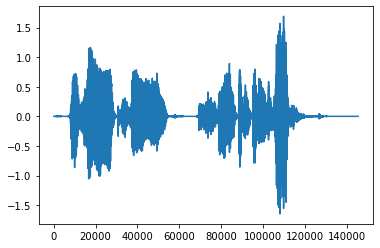

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loudness_normalized_audio)

In [ ]:
sa[0].size()

torch.Size([145536])

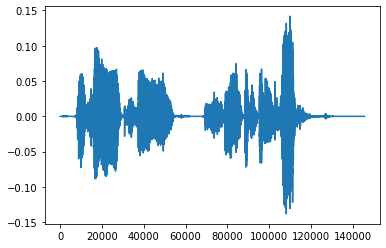

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sa[0].numpy())

In [ ]:
torch.tensor(loudness_normalized_audio).size()

torch.Size([159360])

In [ ]:
sa.shape, data.shape

(torch.Size([1, 159360]), (159360,))

In [ ]:
import soundfile as sf
import pyloudnorm as pyln

def get_loudness_normalised(sa, sr):
    # peak normalize audio to -1 dB
    peak_normalized_audio = pyln.normalize.peak(sa, -1.0)

    # measure the loudness first 
    meter = pyln.Meter(rate) # create BS.1770 meter
    loudness = meter.integrated_loudness(sa)

    # loudness normalize audio to -12 dB LUFS
    loudness_normalized_audio = pyln.normalize.loudness(sa, loudness, -12.0)

    return loudness_normalized_audio

In [ ]:
def get_loudness_stats(sa, sr):
  # Return mean and max loudness given a speeach array and sample rate
  # Credit: https://stackoverflow.com/questions/64913424/how-to-compute-loudness-from-audio-signal
  # Compute the spectrogram (magnitude)
  n_fft = 2048
  hop_length = 1024
  spec_mag = abs(librosa.stft(sa, n_fft=n_fft, hop_length=hop_length))

  # Convert the spectrogram into dB
  spec_db = librosa.amplitude_to_db(spec_mag)

  # Compute A-weighting values
  freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
  a_weights = librosa.A_weighting(freqs)
  a_weights = np.expand_dims(a_weights, axis=1)

  # Apply the A-weghting to the spectrogram in dB
  spec_dba = spec_db + a_weights

  # Compute the "loudness" value
  loudness = librosa.feature.rms(S=librosa.db_to_amplitude(spec_dba))

  return np.mean(loudness[0]), np.max(loudness[0])

In [ ]:
def log_row_to_table(ndx=None, wandb_table=None, ds=None, verbose=True, frame_offset=16_000):
  # frame_offset = how many frames to skip  

  # Grab each item of interest to log
  #speech_array, _ = torchaudio.load(ds["path"][ndx])
  speech_array, tmp_sr = torchaudio.load(ds["path"][ndx], offset=frame_offset)
  sa = speech_array[0].numpy()

  # Resample
  sampling_rate = 16_000
  sa = librosa.resample(np.asarray(sa), 48_000, sampling_rate)
#   print(len(sa))
    
#   speech_array, tmp_sr = torchaudio.load(ds["path"][ndx], offset=48_000)
#   sa2 = speech_array[0].numpy()
#   sa2 = librosa.resample(np.asarray(sa), 48_000, sampling_rate)
#   print(len(sa), len(sa2))
    
  # Normalize by loudness  
  sa_loud_norm = get_loudness_normalised(sa, sampling_rate)

  # Index into the rest of the metadata we'll be logging
  duration = librosa.get_duration(y=sa, sr=sampling_rate) 
  text = ds['sentence'][ndx]
  gender = ds['gender'][ndx]
  fn = ds['path'][ndx].split('/')[-1] 
  age = ds['age'][ndx]
  downvotes = ds['down_votes'][ndx]
  upvotes = ds['up_votes'][ndx]
  accent = ds['accent'][ndx]

  # Example of additional calculated audio stats
  mean_loudness, max_loudness = get_loudness_stats(sa, sampling_rate)

  # Create a Wandb Audio object to log the speech array too
  raw_audio = wandb.Audio(data_or_path=sa, sample_rate=sampling_rate, caption=fn)
    
  # Create object for loudness normalized  
  loud_norm_audio = wandb.Audio(data_or_path=sa_loud_norm, sample_rate=sampling_rate, caption=f'{fn}_ld_norm')

  # Create 1 row for our table with all of the objects we wish to log
  row = [raw_audio, loud_norm_audio, text, duration, mean_loudness, max_loudness, gender, 
         age, downvotes, upvotes, accent, sampling_rate, fn]

  # Add our row to the wandb table
  wandb_table.add_data(*row)

  if verbose: 
    if ndx % 100 == 0: print(ndx)

  return wandb_table

In [ ]:
# Column names for the table we will save to Artifacts
columns = ['speech', 'speech_loud_norm', 'transcription', 'duration', 'mean_loudness', 
           'max_loudness', 'gender', 'age', 'downvotes', 'upvotes', 'accent', 
           'sampling_rate', 'filename']

# Create table object
wandb_table = wandb.Table(columns=columns)

In [ ]:
# %%capture
N_RAND=500
rand_ndxs = np.random.randint(0, len(common_voice_train), N_RAND)
ds = common_voice_train.select(rand_ndxs)

# ds = common_voice_train

# Log to table, row by row
for ndx in range(len(ds)):
  wandb_table = log_row_to_table(ndx=ndx, wandb_table=wandb_table, ds=ds, verbose=True, frame_offset=0)

/opt/conda/lib/python3.7/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/opt/conda/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0


/opt/conda/lib/python3.7/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/opt/conda/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/opt/conda/lib/python3.7/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/opt/conda/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/opt/conda/lib/python3.7/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/opt/conda/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/opt/conda/lib/p

100


/opt/conda/lib/python3.7/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/opt/conda/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/opt/conda/lib/python3.7/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/opt/conda/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/opt/conda/lib/python3.7/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/opt/conda/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/opt/conda/lib/p

200


/opt/conda/lib/python3.7/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/opt/conda/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/opt/conda/lib/python3.7/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/opt/conda/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/opt/conda/lib/python3.7/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/opt/conda/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/opt/conda/lib/p

ValueError: Audio must be have length greater than the block size

In [ ]:
# `type` can be set to whatever makes sense for you
audio_ds_artifact = wandb.Artifact(name="common-voice-ie-train", type="audio-file")

# Add the table to the artifact
audio_ds_artifact.add(wandb_table, "train_set")

<ManifestEntry digest: RJpcxJqs6ImVIN2vNP5RCw==>

In [ ]:
# 1. Create a wandb Run
# providing a `name` and `job_type` are optional but it helps to organise your wandb project
audio_ds_run = wandb.init(name='train_dataset_loud_norm', job_type='dataset_logging',
                          project=project_name, entity=entity, reinit=True)

# 2. Log the artifact to the Run
audio_ds_run.log_artifact(audio_ds_artifact)

# 3. Finish the run
audio_ds_run.finish()

## Save Loudness Normalised Data to File

In [ ]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    batch["speech"] = get_loudness_normalised(speech_array[0].numpy(), sampling_rate) 
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["sentence"]
    return batch

In [ ]:
import torchaudio

def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    batch["speech"] = speech_array[0].numpy()
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["sentence"]
    return batch

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [ ]:
common_voice_train = common_voice_train.map(speech_file_to_array_fn, remove_columns=common_voice_train.column_names)
common_voice_test = common_voice_test.map(speech_file_to_array_fn, remove_columns=common_voice_test.column_names)

Loading cached processed dataset at data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f/cache-ac676fc6ba2a79a2.arrow
Loading cached processed dataset at data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f/cache-ede4a8063fe8da59.arrow


Great, now we've successfully read in all the audio files, but since we know that Common Voice is sampled at 48kHz, we need to resample the audio files to 16kHz. 

Let's make use of the [`librosa`](https://github.com/librosa/librosa) library to downsample the data.

In [ ]:
import librosa
import numpy as np

def resample(batch):
    batch["speech"] = librosa.resample(np.asarray(batch["speech"]), 48_000, 16_000)
    batch["sampling_rate"] = 16_000
    return batch

In [ ]:
common_voice_train = common_voice_train.map(resample, num_proc=4)
common_voice_test = common_voice_test.map(resample, num_proc=4)

Loading cached processed dataset at data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f/cache-44596a8391572b14.arrow


Loading cached processed dataset at data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f/cache-7c17899e9cae662f.arrow
Loading cached processed dataset at data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f/cache-89ca53832c04f8ce.arrow
Loading cached processed dataset at data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f/cache-5b0634846863055d.arrow


Loading cached processed dataset at data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f/cache-081c3d6dcdcafe56.arrow


Loading cached processed dataset at data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f/cache-d922913f158218a5.arrow
Loading cached processed dataset at data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f/cache-04fbd4d089160624.arrow
Loading cached processed dataset at data/common_voice/ga-IE/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f/cache-a4cf71022fabbfcc.arrow


This seemed to have worked! Let's listen to a couple of audio files to better understand the dataset and verify that the audio was correctly loaded. 

**Note**: *You can click the following cell a couple of times to listen to different speech samples.*

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(common_voice_train)-1)

ipd.Audio(data=np.asarray(common_voice_train[rand_int]["speech"]), autoplay=True, rate=16000)

It can be heard, that the speakers change along with their speaking rate, accent, and background environment, etc. Overall, the recordings sound acceptably clear though, which is to be expected from a crowd-sourced read speech corpus.

Let's do a final check that the data is correctly prepared, by printing the shape of the speech input, its transcription, and the corresponding sampling rate.

**Note**: *You can click the following cell a couple of times to verify multiple samples.*

In [ ]:
rand_int = random.randint(0, len(common_voice_train)-1)

print("Target text:", common_voice_train[rand_int]["target_text"])
print("Input array shape:", np.asarray(common_voice_train[rand_int]["speech"]).shape)
print("Sampling rate:", common_voice_train[rand_int]["sampling_rate"])

Target text: an bord a dhíolmhú ó cheanglas i dtaobh ceadúnas paisinéirí 
Input array shape: (76800,)
Sampling rate: 16000


Good! Everything looks fine - the data is a 1-dimensional array, the sampling rate always corresponds to 16kHz, and the target text is normalized.

Finally, we can process the dataset to the format expected by the model for training. We will again make use of the `map(...)` function.

First, we check that the data samples have the same sampling rate of 16kHz.
Second, we extract the `input_values` from the loaded audio file. In our case, this includes only normalization, but for other speech models, this step could correspond to extracting, *e.g.* [Log-Mel features](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). 
Third, we encode the transcriptions to label ids.

**Note**: This mapping function is a good example of how the `Wav2Vec2Processor` class should be used. In "normal" context, calling `processor(...)` is redirected to `Wav2Vec2FeatureExtractor`'s call method. When wrapping the processor into the `as_target_processor` context, however, the same method is redirected to `Wav2Vec2CTCTokenizer`'s call method.
For more information please check the [docs](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#transformers.Wav2Vec2Processor.__call__).

In [ ]:
def prepare_dataset(batch):
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [ ]:
common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_train.column_names, batch_size=8, num_proc=4, batched=True)
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names, batch_size=8, num_proc=4, batched=True)

## Training

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, XLSR-Wav2Vec2 has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning XLSR-Wav2Vec2 requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of XLSR-Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True,
                                          pad_to_multiple_of=8, pad_to_multiple_of_labels=8)

Next, the evaluation metric is defined. As mentioned earlier, the 
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [ ]:
wer_metric = load_metric("wer")

The model will return a sequence of logit vectors:
$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

A logit vector $\mathbf{y}_1$ contains the log-odds for each word in the vocabulary we defined earlier, thus $\text{len}(\mathbf{y}_i) =$ `config.vocab_size`. We are interested in the most likely prediction of the model and thus take the `argmax(...)` of the logits. Also, we transform the encoded labels back to the original string by replacing `-100` with the `pad_token_id` and decoding the ids while making sure that consecutive tokens are **not** grouped to the same token in CTC style ${}^1$.

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Now, we can load the pretrained `XLSR-Wav2Vec2` checkpoint. The tokenizer's `pad_token_id` must be to define the model's `pad_token_id` or in the case of `Wav2Vec2ForCTC` also CTC's *blank token* ${}^2$. To save GPU memory, we enable PyTorch's [gradient checkpointing](https://pytorch.org/docs/stable/checkpoint.html) and also set the loss reduction to "*mean*".

Because the dataset is quite small (~6h of training data) and because Common Voice is quite noisy, fine-tuning Facebook's [wav2vec2-large-xlsr-53 checkpoint](https://huggingface.co/facebook/wav2vec2-large-xlsr-53) seems to require some hyper-parameter tuning. Therefore, I had to play around a bit with different values for dropout, [SpecAugment](https://arxiv.org/abs/1904.08779)'s masking dropout rate, layer dropout, and the learning rate until training seemed to be stable enough. 

**Note**: When using this notebook to train XLSR-Wav2Vec2 on another language of Common Voice those hyper-parameter settings might not work very well. Feel free to adapt those depending on your use case. 

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53", 
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True, 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The first component of XLSR-Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretraining and as stated in the [paper](https://arxiv.org/pdf/2006.13979.pdf) does not need to be fine-tuned anymore. 
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [ ]:
model.freeze_feature_extractor()

In a final step, we define all parameters related to training. 
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Common Voice dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

**Note**: If one wants to save the trained models in his/her google drive the commented-out `output_dir` can be used instead.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="data",
  # output_dir="./wav2vec2-large-xlsr-turkish-demo",
  group_by_length=True,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  gradient_accumulation_steps=1,
  evaluation_strategy="steps",
  num_train_epochs=50,
  fp16=True,
  save_steps=25,
  eval_steps=25,
  logging_steps=5,
  learning_rate=3e-4,
  warmup_steps=200,
  save_total_limit=1,
    
  # WANDB LOGGING: 
  report_to = 'wandb',  # enable logging to W&B
  run_name = 'ie-base-50e-ovh-4-4-upgrade',   # Name your run, optional
  load_best_model_at_end = True,  # This will ensure your best model will be uploaded to W&B
  metric_for_best_model='wer',    # Load best model based on "wer", not eval loss
  greater_is_better=False,
)

Now, all instances can be passed to Trainer and we are ready to start training!

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
)



---

${}^1$ To allow models to become independent of the speaker rate, in CTC, consecutive tokens that are identical are simply grouped as a single token. However, the encoded labels should not be grouped when decoding since they don't correspond to the predicted tokens of the model, which is why the `group_tokens=False` parameter has to be passed. If we wouldn't pass this parameter a word like `"hello"` would incorrectly be encoded, and decoded as `"helo"`.

${}^2$ The blank token allows the model to predict a word, such as `"hello"` by forcing it to insert the blank token between the two l's. A CTC-conform prediction of `"hello"` of our model would be `[PAD] [PAD] "h" "e" "e" "l" "l" [PAD] "l" "o" "o" [PAD]`.

### Training

Training will take between 180 and 240 minutes depending on the GPU allocated to this notebook. While the trained model yields somewhat satisfying results on *Common Voice*'s test data of Turkish, it is by no means an optimally fine-tuned model. The purpose of this notebook is to demonstrate how XLSR-Wav2Vec2's [checkpoint](https://huggingface.co/facebook/wav2vec2-large-xlsr-53) can be fine-tuned on a low-resource ASR dataset.

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (*right mouse click -> inspect -> Console tab and insert code*).

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

In [ ]:
!df -h

Filesystem                                        Size  Used Avail Use% Mounted on
overlay                                           388G  126G  263G  33% /
tmpfs                                              64M     0   64M   0% /dev
tmpfs                                              87G     0   87G   0% /sys/fs/cgroup
/dev/sda1                                         388G  126G  263G  33% /home
10.98.115.129,10.97.15.129,10.97.7.129:/ovh/data  8.6T  274G  8.3T   4% /workspace/data
tmpfs                                              87G   56K   87G   1% /dev/shm
tmpfs                                              87G   12K   87G   1% /proc/driver/nvidia
udev                                               87G     0   87G   0% /dev/nvidia1
tmpfs                                              87G     0   87G   0% /proc/acpi
tmpfs                                              87G     0   87G   0% /proc/scsi
tmpfs                                              87G     0   87G   0% /sys/firmware


In [ ]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step,Training Loss,Validation Loss,Wer,Runtime,Samples Per Second
25,16.910900,19.851835,0.999707,50.199500,10.080000
50,11.013100,9.274652,0.999707,49.676000,10.186000
75,3.909600,3.731420,0.999707,49.708100,10.179000
100,3.116000,3.093797,0.999707,49.602700,10.201000
125,3.027200,3.029405,0.999707,50.286700,10.062000
150,2.985200,2.969006,0.999707,50.159000,10.088000
175,2.995400,2.992875,0.999707,49.755800,10.170000
200,2.964600,2.920878,0.999707,51.081200,9.906000
225,2.918800,2.924300,0.999707,49.780900,10.165000
250,2.922700,2.950752,0.999707,50.190600,10.082000


TrainOutput(global_step=1650, training_loss=1.3173199103456554, metrics={'train_runtime': 8759.7664, 'train_samples_per_second': 0.188, 'total_flos': 6.579265506797722e+18, 'epoch': 50.0, 'init_mem_cpu_alloc_delta': 58580, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 0, 'train_mem_gpu_alloc_delta': 5058206720, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 0})

In [ ]:
wandb.finish()

train/loss,0.0835
train/learning_rate,0.0
train/epoch,50.0
_runtime,8760
_timestamp,1616457715
_step,1650
eval/loss,1.29677
eval/wer,0.59391
eval/runtime,52.0412
eval/samples_per_second,9.723
train/train_runtime,8759.7664


train/loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▂▃▅▆▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/wer,██████████▇▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▂▁▁▂▁▁▁▂▁▂▂██▂▄▂▂▂▃▂▄▃▅▃▄▃▃▄▄▃▃▅▆▃▅▃▄▄▄▄
eval/samples_per_second,▇██▇███▇█▇▇▁▁▇▅▇▇▇▆▇▅▆▄▆▅▅▆▅▅▆▆▄▃▆▄▆▅▄▅▅
train/train_runtime,▁


In [ ]:
!df -h

Filesystem                                        Size  Used Avail Use% Mounted on
overlay                                           388G  129G  259G  34% /
tmpfs                                              64M     0   64M   0% /dev
tmpfs                                              87G     0   87G   0% /sys/fs/cgroup
/dev/sda1                                         388G  129G  259G  34% /home
10.98.115.129,10.97.15.129,10.97.7.129:/ovh/data  8.6T  287G  8.3T   4% /workspace/data
tmpfs                                              87G   80K   87G   1% /dev/shm
tmpfs                                              87G   12K   87G   1% /proc/driver/nvidia
udev                                               87G     0   87G   0% /dev/nvidia1
tmpfs                                              87G     0   87G   0% /proc/acpi
tmpfs                                              87G     0   87G   0% /proc/scsi
tmpfs                                              87G     0   87G   0% /sys/firmware


The training loss goes down and we can see that the WER on the test set also improves nicely. Because this notebook is just for demonstration purposes, we can stop here.

The resulting model of this notebook has been saved to [`patrickvonplaten/wav2vec2-large-xlsr-turkish-demo`](https://huggingface.co/patrickvonplaten/wav2vec2-large-xlsr-turkish-demo)

As a final check, let's load the model and verify that it indeed has learned to transcribe Turkish speech.

Let's first load the pretrained checkpoint.

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53", 
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True, 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
  output_dir="data",
  # output_dir="./wav2vec2-large-xlsr-turkish-demo",
  group_by_length=True,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  gradient_accumulation_steps=1,
  evaluation_strategy="steps",
  num_train_epochs=50,
  fp16=True,
  save_steps=25,
  eval_steps=25,
  logging_steps=5,
  learning_rate=1e-4,
  warmup_steps=100,
  save_total_limit=1,
    
  # WANDB LOGGING: 
  report_to = 'wandb',  # enable logging to W&B
  run_name = 'ie1e-4-100w-50e-ovh-4-4-upgrade',   # Name your run, optional
  load_best_model_at_end = True,  # This will ensure your best model will be uploaded to W&B
  metric_for_best_model='wer',    # Load best model based on "wer", not eval loss
  greater_is_better=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
)

In [ ]:
trainer.train()
wandb.finish()

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step,Training Loss,Validation Loss,Wer,Runtime,Samples Per Second
25,16.784000,19.620174,0.998245,51.626700,9.801000
50,15.071400,18.899715,0.999707,49.470100,10.228000
75,8.792200,7.581682,0.999707,50.218100,10.076000
100,3.581600,3.452944,0.999707,50.533300,10.013000
125,3.100200,3.082635,0.999707,50.991300,9.923000
150,3.014100,3.002206,0.999707,52.654900,9.610000
175,2.968600,2.963183,0.999707,49.323200,10.259000
200,2.995100,2.944443,0.999707,49.598100,10.202000
225,2.930400,2.934498,0.999707,49.725900,10.176000
250,2.937100,2.929278,0.999707,50.130900,10.094000


train/loss,0.3555
train/learning_rate,0.0
train/epoch,50.0
_runtime,8923
_timestamp,1616466713
_step,1650
eval/loss,1.05039
eval/wer,0.66618
eval/runtime,50.4227
eval/samples_per_second,10.035
train/train_runtime,8922.7199


train/loss,██▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▂▅███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/loss,██▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/wer,████████████▇█▆▅▅▃▃▃▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▆▁▃█▁▂▃▃▃▂▂▂▂▂▂▂▂▃▃▃▃▃▃▇▃▇▃▇▇▃▅▃▃▃██▇▄▄▃
eval/samples_per_second,▃█▆▁█▇▆▆▆▇▇▇▇▇▇▇▇▆▅▆▆▆▆▂▆▁▆▂▂▆▄▆▆▆▁▁▂▅▅▆
train/train_runtime,▁


In [ ]:
# !pip uninstall -y transformers

In [ ]:
%%capture
!pip install git+https://github.com/huggingface/transformers.git

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53", 
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True, 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
  output_dir="data",
  # output_dir="./wav2vec2-large-xlsr-turkish-demo",
  group_by_length=True,
  per_device_train_batch_size=48,
  per_device_eval_batch_size=64,
  gradient_accumulation_steps=1,
  evaluation_strategy="steps",
  num_train_epochs=50,
  fp16=True,
  save_steps=25,
  eval_steps=25,
  logging_steps=5,
  learning_rate=1e-4,
  warmup_steps=400,
  save_total_limit=1,
    
  # WANDB LOGGING: 
  report_to = 'wandb',  # enable logging to W&B
  run_name = 'ie1e-4-400w-50e-ovh-4-5-upgrade',   # Name your run, optional
  load_best_model_at_end = True,  # This will ensure your best model will be uploaded to W&B
  metric_for_best_model='wer',    # Load best model based on "wer", not eval loss
  greater_is_better=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
)

In [ ]:
trainer.train()
wandb.finish()

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step,Training Loss,Validation Loss,Wer,Runtime,Samples Per Second
25,15.702500,20.250538,1.000000,50.413300,10.037000
50,15.459100,20.032469,1.000000,49.023600,10.322000
75,16.054300,19.705692,1.000000,49.322400,10.259000
100,16.154700,19.339045,1.000000,50.047800,10.110000
125,15.301700,18.895893,1.000000,49.732800,10.174000
150,15.013600,18.419765,1.000000,49.260600,10.272000
175,9.856300,6.735880,1.000000,49.304300,10.263000
200,3.896700,3.723217,1.000000,50.054900,10.109000
225,3.293600,3.194918,1.000000,50.492500,10.021000
250,3.064100,3.075306,1.000000,49.513800,10.219000


train/loss,0.5744
train/learning_rate,0.0
train/epoch,50.0
_runtime,7883
_timestamp,1616495509
_step,1100
eval/loss,1.04582
eval/wer,0.72177
eval/runtime,50.4932
eval/samples_per_second,10.021
train/train_runtime,7883.305


train/loss,█▇█▇▆▆▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▂▂▃▃▃▄▅▅▆▆▆▇▇███▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/loss,█████▇▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/wer,▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁
eval/runtime,▃▁▁▂▂▁▁▂▃▂▃▂▂▇█▆▆▅▆▅█▆▇▇▄▇▅▃▂▂▃▃▂▂▃▂▃▃▃▃
eval/samples_per_second,▆██▇▇██▆▆▇▆▇▇▂▁▃▃▄▃▄▁▃▂▂▅▂▃▆▇▇▆▆▇▆▆▇▆▆▆▆
train/train_runtime,▁


## With Dropout

In [ ]:
from transformers import Wav2Vec2ForCTC
from transformers import TrainingArguments
from transformers import Trainer

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53", 
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.1,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True, 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.freeze_feature_extractor()

In [ ]:
training_args = TrainingArguments(
  output_dir="data",
  # output_dir="./wav2vec2-large-xlsr-turkish-demo",
  group_by_length=True,
  per_device_train_batch_size=48,
  per_device_eval_batch_size=64,
  gradient_accumulation_steps=1,
  evaluation_strategy="steps",
  num_train_epochs=50,
  fp16=True,
  save_steps=25,
  eval_steps=25,
  logging_steps=5,
  learning_rate=1e-4,
  warmup_steps=100,
  save_total_limit=1,
    
  # WANDB LOGGING: 
  report_to = 'wandb',  # enable logging to W&B
  run_name = 'ie1e-4-100w-d-o',   # Name your run, optional
  load_best_model_at_end = True,  # This will ensure your best model will be uploaded to W&B
  metric_for_best_model='wer',    # Load best model based on "wer", not eval loss
  greater_is_better=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
)

In [ ]:
trainer.train()
wandb.finish()

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step,Training Loss,Validation Loss,Wer,Runtime,Samples Per Second
25,15.554500,19.991453,1.000000,51.343500,9.855000
50,14.680000,19.053507,1.000000,50.464000,10.027000
75,13.980400,17.558977,1.000000,50.705100,9.979000
100,8.818000,4.919689,1.000000,50.143100,10.091000
125,3.298300,3.217547,1.000000,50.669200,9.986000
150,3.081700,3.042261,1.000000,50.392100,10.041000
175,3.028000,3.013988,1.000000,50.371200,10.045000
200,2.980600,3.010421,1.000000,50.736800,9.973000
225,3.003500,2.996748,1.000000,51.841000,9.761000
250,2.933300,2.951648,1.000000,50.574900,10.005000


## Dropout (?) Remove "(,),-" and drop lr ro 3e-5 and pad to multiple

In [ ]:
from transformers import Wav2Vec2ForCTC
from transformers import TrainingArguments
from transformers import Trainer

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53", 
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.1,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True, 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.freeze_feature_extractor()

In [ ]:
training_args = TrainingArguments(
  output_dir="data",
  # output_dir="./wav2vec2-large-xlsr-turkish-demo",
  group_by_length=True,
  per_device_train_batch_size=48,
  per_device_eval_batch_size=64,
  gradient_accumulation_steps=1,
  evaluation_strategy="steps",
  num_train_epochs=50,
  fp16=True,
  save_steps=25,
  eval_steps=25,
  logging_steps=5,
  learning_rate=1e-4,
  warmup_steps=100,
  save_total_limit=1,
    
  # WANDB LOGGING: 
  report_to = 'wandb',  # enable logging to W&B
  run_name = 'ie1e-4-100w-d-o',   # Name your run, optional
  load_best_model_at_end = True,  # This will ensure your best model will be uploaded to W&B
  metric_for_best_model='wer',    # Load best model based on "wer", not eval loss
  greater_is_better=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
)

In [ ]:
trainer.train()
wandb.finish()

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Step,Training Loss,Validation Loss,Wer,Runtime,Samples Per Second
25,15.554500,19.991453,1.000000,51.343500,9.855000
50,14.680000,19.053507,1.000000,50.464000,10.027000
75,13.980400,17.558977,1.000000,50.705100,9.979000
100,8.818000,4.919689,1.000000,50.143100,10.091000
125,3.298300,3.217547,1.000000,50.669200,9.986000
150,3.081700,3.042261,1.000000,50.392100,10.041000


In [ ]:
model = Wav2Vec2ForCTC.from_pretrained("patrickvonplaten/wav2vec2-large-xlsr-turkish-demo").to("cuda")
processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wav2vec2-large-xlsr-turkish-demo")

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Now, we will just take the first example of the test set, run it through the model and take the `argmax(...)` of the logits to retrieve the predicted token ids.

In [ ]:
input_dict = processor(common_voice_test["input_values"][0], return_tensors="pt", padding=True)

logits = model(input_dict.input_values.to("cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.


We adapted `common_voice_test` quite a bit so that the dataset instance does not contain the original sentence label anymore. Thus, we re-use the original dataset to get the label of the first example.

In [ ]:
common_voice_test_transcription = load_dataset("common_voice", "tr", data_dir="./cv-corpus-6.1-2020-12-11", split="test")

Using custom data configuration tr-ad9f7b76efa9f3a0
Reusing dataset common_voice (/root/.cache/huggingface/datasets/common_voice/tr-ad9f7b76efa9f3a0/6.1.0/32954a9015faa0d840f6c6894938545c5d12bc5d8936a80079af74bf50d71564)


Finally, we can decode the example.

In [ ]:
print("Prediction:")
print(processor.decode(pred_ids))

print("\nReference:")
print(common_voice_test_transcription["sentence"][0].lower())


Prediction:
hata küçük şeyler için birbüy bi şeyler kolaluyor ve yenekiçük şeyler için bir bimizi inciltiyoruz

Reference:
hayatta küçük şeyleri kovalıyor ve yine küçük şeyler için birbirimizi incitiyoruz.


Alright! The transcription can definitely be recognized from our prediction, but it is far from being perfect. Training the model a bit longer, spending more time on the data preprocessing, and especially using a language model for decoding would certainly improve the model's overall performance. 

For a demonstration model on a low-resource language, the results are acceptable, however 🤗.